

---
**Model 3**: LassoRegressor with upsampling and  feature engineering.

**To check the performance, simply run the following code cell, and result should be print out immediately.**

the code for plotting and visualisation are also followed

File loaded locally! 
Start training Lasso regressor...
Training finished! Start predicting...
The Performance of Our Lasso regressor:
MSE:   105.419
RMSE:  10.267
MAD:   2.364
MAE:   6.34
NLL:   698.689
RR:    -0.084
AUC:   0.656
Explained variance regression score: -0.077
Time taken to run Logistic Regression = 1.8126661777496338 seconds


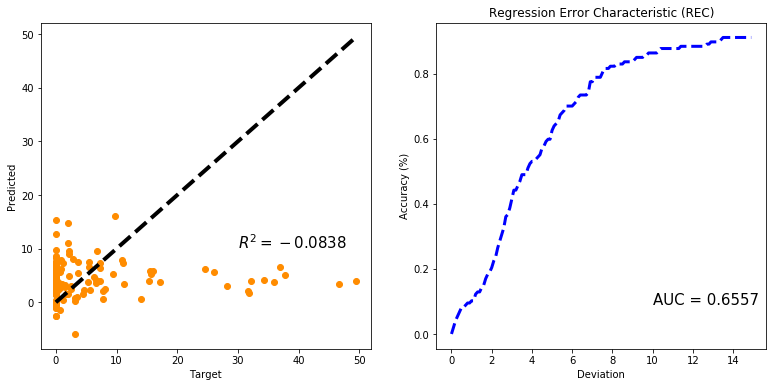

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from scipy.integrate import simps
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
# make stable output
np.random.seed(123)

# start the execution time
start_time=time.time()

# store data into a pandas.DataFrame
try:
    data = pd.read_csv('forestfires.csv')
    print("File loaded locally! ")
except FileNotFoundError:
    try:
        data = pd.read_csv('./data/forestfires.csv')
        print("File loaded locally! ")
    except FileNotFoundError:
        url = 'https://raw.githubusercontent.com/haichenzhu/Forest-Fire-Area-Prediction/master/forestfires.csv'
        data = pd.read_csv(url)
        print("File loaded online! From: ", url)
except:
    print("No file named forestfires.csv in the ./data directory or no Internet access! Mission Failed! ")

# remove these month due to there are few record
remove_month = ['nov', 'jan', 'may']
fire_data = data.drop(data[data.month.isin(remove_month)].index, axis=0)

# classifier area values into 6 groups
fire_data['area_bins'] = pd.cut(fire_data['area'], bins=[0, 5, 10, 50, 100, 150, 1100], 
                                include_lowest=True,
                                labels=['0-5', '5-10', '10-50', '50-100', '100-150', '>150'])

# delete the record when the area is larger than 50, due there is few records
fire_data.drop(fire_data[fire_data.area>50].index, axis=0, inplace=True)

# make these two object type feature's value to numerical values
fire_data_num = fire_data
fire_data_num.month.replace(('jan', 'feb', 'mar', 'apr', 'may', 'jun',
                             'jul', 'aug', 'sep', 'oct', 'nov', 'dec'),
                            (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), inplace=True)
fire_data_num.day.replace(('mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'),
                          (1, 2, 3, 4, 5, 6, 7), inplace=True)
fire=fire_data_num

#select predictor variables and target variable as separate data sets  
predvar = fire[["X", "Y", "month", "day", "FFMC", "DMC", "DC", 
                "ISI", "temp", "RH", "wind", "rain"]]
target = fire.area

# split data into train and test sets
spliter = StratifiedShuffleSplit(random_state=34, n_splits=1, test_size=0.3)

train_index = fire.index
test_index = fire.index
for tr, te in spliter.split(fire.values, fire.area_bins.values):
    train_index = tr
    test_index = te
pred_train = predvar.iloc[train_index]
pred_test = predvar.iloc[test_index]
tar_train = target.iloc[train_index]
tar_test = target.iloc[test_index]


def rec(y_true , y_predict):
    '''
    Regression Error Characteristic curve with X-axis represents deviation, and y-axis shows 
    the current accuracy under deviation, return the range of deviation, the accuracy of every
    deviation, the area under the curve
    '''
    accuracy = []
    begin = 0
    end = 15
    interval = 0.1
    
    epsilon = np.arange(begin, end, interval)
    
    # loop to find the accuracy for every deviation
    for i in range(len(epsilon)):
        count = 0
        for j in range(len(y_true)):
            if np.abs(y_true[j] - y_predict[j]) < epsilon[i]:
                count = count + 1
        
        accuracy.append(count/len(y_true))
    
    #  using Simpson's rule to calculating area-under-curve
    area_under_curve = simps(accuracy, epsilon) / end
   
    return epsilon, accuracy, area_under_curve


def NLL(y_true, y_predict):
    '''
    defined as : −log𝑝(𝑦|𝐷,𝑥), 
    where y is the true value, D is the dataset, x represents a query point
    '''
    y_predict_mean = np.mean(y_predict)
    y_predict_variance = np.var(y_predict)
    
    return np.log(2 * np.pi * y_predict_variance) / 2 + \
            np.sum((y_true - y_predict_mean) ** 2) / (2 * y_predict_variance)


def mean_absolute_deviation(y_predict):
    '''
    the mean absolue deviation of every prediction to the prediction mean, defined as:
    mean(abs(p - y_predict.mean() for p in y_predict))
    '''
    prediction_mean = np.mean(y_predict)
    distance = np.abs(y_predict - prediction_mean)
    return np.sum(distance) / len(y_predict)


# make a pipline to do polynomial features and lasso regession sequantly
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('lasso', Lasso(fit_intercept=False, max_iter=800000))])

print("Start training Lasso regressor...")
model.fit(pred_train, tar_train)

# predicting
print('Training finished! Start predicting...')
y_predict = model.predict(pred_test)
y_true = tar_test

# print out performance
print('The Performance of Our Lasso regressor:')
mse = mean_squared_error(y_true, y_predict)
rmse = np.sqrt(mse)
print('MSE:  ', mse.round(3))
print('RMSE: ', rmse.round(3))
print('MAD:  ', mean_absolute_deviation(y_predict).round(3))
print('MAE:  ', mean_absolute_error(y_true, y_predict).round(3))
print('NLL:  ', NLL(y_true, y_predict).round(3))

rr = r2_score(y_true, y_predict)
print('RR:   ', rr.round(3))

deviation, accuracy, area_under_curve = rec(y_true.to_numpy(), y_predict)
print('AUC:  ', area_under_curve.round(3))

print("Explained variance regression score:", explained_variance_score(y_true, y_predict).round(3))

# record the running time 
elapsed_time = time.time() - start_time
print("Time taken to run Logistic Regression =", elapsed_time, "seconds")

# Plotting
plt.figure(figsize=(13 , 6))

plt.subplot(1, 2, 1)
plt.scatter(y_true, y_predict, color="darkorange")
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.text(30, 10, r"$R^2 = %0.4f$" %rr, fontsize=15)

plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(deviation, accuracy, "--b", lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(10, 0.09, "AUC = %0.4f" %area_under_curve, fontsize=15)

plt.show()

